# Process plate counts to get ratios of variants and determine pooling and MOI
This notebook is designed to be run using `snakemake`, and analyzes a plate of sequencing-based neutralization assays.

The plots generated by this notebook are interactive, so you can mouseover points for details, use the mouse-scroll to zoom and pan, and use interactive dropdowns at the bottom of the plots.

## Setup
Import Python modules:

In [1]:
import pickle
import sys

import altair as alt

import matplotlib.pyplot as plt

import numpy

import pandas as pd
from os.path import join
import os
import ruamel.yaml as yaml

_ = alt.data_transformers.disable_max_rows()

Get the variables passed by `snakemake`:

In [22]:
viral_library_csv = "../data/viral_libraries/H1N1_2023_library.csv"
viral_strain_plot_order = "../data/H1N1library_2023-2024_allStrains.csv"
viruses_to_plot = pd.read_csv(viral_strain_plot_order)
viruses = viruses_to_plot.strain.tolist()
neut_standard_set_csv = "../data/neut_standard_sets/loes2023_neut_standards.csv"
filepath_prefix = "../"
barcode_runs_df = pd.read_csv("../data/plates/plate2_repoolrepassage.csv")
barcode_runs_df.drop(columns=["fastq"], inplace=True)
barcode_runs_df["sample"] = barcode_runs_df.apply(
    lambda x: "-".join(x.astype(str)), axis=1
)

samples = barcode_runs_df["well"].unique().tolist()
print(f"There are {len(samples)} barcode runs.")

file_list = os.listdir(r'../results/miscellaneous_plates/plate2_repool')
count_csvs = []
for f in file_list:
    location = '../results/miscellaneous_plates/plate2_repool/' + f
    if "_counts" in f:
        count_csvs.append(location)

# file_list_withdir
fate_csvs = []
file_list = os.listdir(r'../results/miscellaneous_plates/plate2_repool/')
for f in file_list:
    location = '../results/miscellaneous_plates/plate2_repool/' + f
    if "_fates" in f:
        fate_csvs.append(location)

samples_df = barcode_runs_df[['well','serum','sample','dilution_factor','replicate']].copy()
samples_df

There are 16 barcode runs.


,well,serum,sample,dilution_factor,replicate
0,A1,none,0-A1-none-3-1,3,1
1,A2,none,1-A2-none-3-2,3,2
2,B1,none,2-B1-none-9-1,9,1
3,B2,none,3-B2-none-9-2,9,2
4,C1,none,4-C1-none-27-1,27,1
5,C2,none,5-C2-none-27-2,27,2
6,D1,none,6-D1-none-81-1,81,1
7,D2,none,7-D2-none-81-2,81,2
8,E1,none,8-E1-none-243-1,243,1
9,E2,none,9-E2-none-243-2,243,2


## Statistics on barcode-parsing for each sample
Make interactive chart of the "fates" of the sequencing reads parsed for each sample on the plate.

If most sequencing reads are not "valid barcodes", this could potentially indicate some problem in the sequencing or barcode set you are parsing.

Potential fates are:
 - *valid barcode*: barcode that matches a known virus or neutralization standard, we hope most reads are this.
 - *invalid barcode*: a barcode with proper flanking sequences, but does not match a known virus or neutralization standard. If you  have a lot of reads of this type, it is probably a good idea to look at the invalid barcode CSVs (in the `./results/barcode_invalid/` subdirectory created by the pipeline) to see what these invalid barcodes are.
 - *unparseable barcode*: could not parse a barcode from this read as there was not a sequence of the correct length with the appropriate flanking sequence.
 - *low quality barcode*: low-quality or `N` nucleotides in barcode, could indicate problem with sequencing.
 - *failed chastity filter*: reads that failed the Illumina chastity filter, if these are reported in the FASTQ (they may not be).

Also, if the number of reads per sample is very uneven, that could indicate that you did not do a good job of balancing the different samples in the Illumina sequencing.

In [23]:
fates = (
    pd.concat([pd.read_csv(f).assign(well=f.strip("../results/miscellaneous_plates/plate2_repool/").strip('_fates.csv')) for f, s in zip(fate_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .assign(
        fate_counts=lambda x: x.groupby("fate")["count"].transform("sum"),
        sample_well=lambda x: x["serum"] + " (" + x["well"] + ")",
    )
    .query("fate_counts > 0")[  # only keep fates with at least one count
        ["fate", "count", "well", "sample_well", "dilution_factor"]
    ]
)
fates
assert len(fates) == len(fates.drop_duplicates())


sample_wells = list(fates.sort_values(["dilution_factor"])["sample_well"])


fates_chart = (
    alt.Chart(fates)
    .encode(
        alt.X("count", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "sample_well",
            title=None,
            sort=sample_wells,
        ),
        alt.Color("fate", sort=sorted(fates["fate"].unique(), reverse=True)),
        alt.Order("fate", sort="descending"),
        tooltip=fates.columns.tolist(),
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=200,
        title=f"Barcode parsing for initial titering plate",
    )
    .configure_axis(grid=False)
)

fates_chart
#fates

alt.Chart(...)

## Read barcode counts
Read the counts per barcode:

In [24]:
# get barcode counts
counts = (
    pd.concat([pd.read_csv(c).assign(well=c.strip("../results/miscellaneous_plates/plate2_repool/").strip('_counts.csv')) for c, s in zip(count_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .drop(columns=["replicate"])
    .assign(sample_well=lambda x: x["sample"] + " (" + x["well"] + ")")
)

# classify barcodes as viral or neut standard
barcode_class = pd.concat(
    [
        pd.read_csv(viral_library_csv)[["barcode", "strain"]].assign(
            neut_standard=False,
        ),
        pd.read_csv(neut_standard_set_csv)[["barcode"]].assign(
            neut_standard=True,
            strain=pd.NA,
        ),
    ],
    ignore_index=True,
)

# merge counts and classification of barcodes
assert set(counts["barcode"]) == set(barcode_class["barcode"])
counts = counts.merge(barcode_class, on="barcode", validate="many_to_one")
counts

,barcode,count,well,serum,sample,dilution_factor,sample_well,strain,neut_standard
0,GTACAAACCTGCAAAT,373637,H2,none,15-H2-none-6561-2,6561,15-H2-none-6561-2 (H2),NaN,True
1,CAATTAGAAATACATA,299587,H2,none,15-H2-none-6561-2,6561,15-H2-none-6561-2 (H2),NaN,True
2,TACCCTGCAAGCCACT,275305,H2,none,15-H2-none-6561-2,6561,15-H2-none-6561-2 (H2),NaN,True
3,AAAAAATTTATGACAA,271646,H2,none,15-H2-none-6561-2,6561,15-H2-none-6561-2 (H2),NaN,True
4,AACCACCGAGTGACCG,241933,H2,none,15-H2-none-6561-2,6561,15-H2-none-6561-2 (H2),NaN,True
...,...,...,...,...,...,...,...,...,...
3291,AGCAGTAAATAAAATC,0,A2,none,1-A2-none-3-2,3,1-A2-none-3-2 (A2),A/Oregon/Flu-OHSU-241140095/2023,False
3292,CAAGGAAACCGGTTGA,0,A2,none,1-A2-none-3-2,3,1-A2-none-3-2 (A2),A/Oregon/Flu-OHSU-241140095/2023,False
3293,CCAGGAACAATATATC,0,A2,none,1-A2-none-3-2,3,1-A2-none-3-2 (A2),A/Cambodia/SVH230198/2023,False
3294,CCCACCCCTGCCTCCC,0,A2,none,1-A2-none-3-2,3,1-A2-none-3-2 (A2),A/Singapore/GP7085/2023,False


Apply any manually specified data drops:

## Average counts per barcode in each well

Plot average counts per barcode.
If a sample has inadequate barcode counts, it may not have good enough statistics for accurate analysis, and a QC-threshold is applied:

In [25]:
avg_barcode_counts = (
    counts.groupby(
        ["well", "sample_well"],
        dropna=False,
        as_index=False,
    )
    .aggregate(avg_count=pd.NamedAgg("count", "mean"))
    .assign(
        fails_qc=lambda x: (
            x["avg_count"] < 500
        ),
    )
)

avg_barcode_counts_chart = (
    alt.Chart(avg_barcode_counts)
    .encode(
        alt.X(
            "avg_count",
            title="average barcode counts per well",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {'min barcode count threshold'=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if avg_barcode_counts[c].dtype == float else c
            for c in avg_barcode_counts.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Average barcode counts per well for titering plate",
    )
    .configure_axis(grid=False)
)

display(avg_barcode_counts_chart)

# drop wells failing QC
avg_barcode_counts_per_well_drops = list(avg_barcode_counts.query("fails_qc")["well"])

alt.Chart(...)

## Fraction of counts from neutralization standard
Determine the fraction of counts from the neutralization standard in each sample, and make sure this fraction passess the QC threshold.

In [26]:
neut_standard_fracs = (
    counts.assign(
        neut_standard_count=lambda x: x["count"] * x["neut_standard"].astype(int)
    )
    .groupby(
        ["well", "sample_well"],
        dropna=False,
        as_index=False,
    )
    .aggregate(
        total_count=pd.NamedAgg("count", "sum"),
        neut_standard_count=pd.NamedAgg("neut_standard_count", "sum"),
    )
    .assign(
        neut_standard_frac=lambda x: x["neut_standard_count"] / x["total_count"],
        fails_qc=lambda x: (
            x["neut_standard_frac"] < 0.001
        ),
    )
)

neut_standard_fracs_chart = (
    alt.Chart(neut_standard_fracs)
    .encode(
        alt.X(
            "neut_standard_frac",
            title="frac counts from neutralization standard per well",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {'min_neut_standard_frac_per_well'=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if neut_standard_fracs[c].dtype == float else c
            for c in neut_standard_fracs.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Neutralization-standard fracs per well for titering plate",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(neut_standard_fracs_chart)


alt.Chart(...)

Text(0.5, 1.0, 'Determining Linear Range')

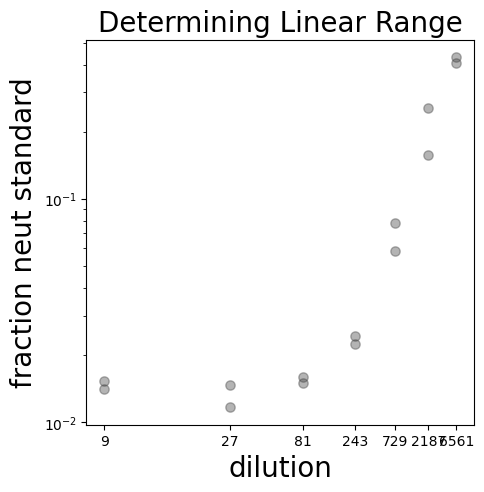

In [27]:
#neut_standard_fracs['dilution'] = neut_standard_fracs['sample_well'].str.split('-').str[2].astype(int)
#neut_standard_fracs.plot.scatter(x='dilution',y='neut_standard_frac',c='#444444',s=45, xlabel='dilution', ylabel="neut_standard_frac", fontsize=12,figsize=(10,5), alpha=0.4, logx=True)
neut_standard_fracs = neut_standard_fracs.loc[~neut_standard_fracs['sample_well'].str.contains("NoVirus")]
neut_standard_fracs['dilution'] = neut_standard_fracs['sample_well'].str.split('-').str[3]
ax1 = neut_standard_fracs.plot.scatter(x='dilution',y='neut_standard_frac',c='#444444',s=45, xlabel='dilution', ylabel="neut_standard_frac", fontsize=10,figsize=(5,5), alpha=0.4, loglog=True)
ax1.set_ylabel('fraction neut standard',fontdict={'fontsize':20})
ax1.set_xlabel('dilution',fontdict={'fontsize':20})
ax1.set_title('Determining Linear Range',fontdict={'fontsize':20})


In [28]:
counts_balancedbarcode = counts.groupby(['sample','strain','dilution_factor','serum','well','barcode']).sum()
counts_balancedbarcode = counts_balancedbarcode.reset_index().drop(columns = ['neut_standard'])
counts_balancedbarcode

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well
0,0-A1-none-3-1,A/Argentina/677/2023,3,none,A1,ATATCAAGACTAGATG,8355,0-A1-none-3-1 (A1)
1,0-A1-none-3-1,A/Argentina/677/2023,3,none,A1,CCGTTCTAAAACGCTA,3655,0-A1-none-3-1 (A1)
2,0-A1-none-3-1,A/Argentina/677/2023,3,none,A1,CGGCAGGATATTGCAG,6487,0-A1-none-3-1 (A1)
3,0-A1-none-3-1,A/Argentina/824/2023,3,none,A1,ACAAATAGTTTATAGA,25463,0-A1-none-3-1 (A1)
4,0-A1-none-3-1,A/Argentina/824/2023,3,none,A1,CCACATAGGCGTTTTT,3358,0-A1-none-3-1 (A1)
...,...,...,...,...,...,...,...,...
3147,9-E2-none-243-2,A/Wisconsin/588/2019,243,none,E2,GAAGAAACTATAACCA,10085,9-E2-none-243-2 (E2)
3148,9-E2-none-243-2,A/Wisconsin/588/2019,243,none,E2,TATATTAGTAACATAA,2858,9-E2-none-243-2 (E2)
3149,9-E2-none-243-2,A/Wisconsin/67/2022,243,none,E2,AAAGCTCTTTTCGTTC,189009,9-E2-none-243-2 (E2)
3150,9-E2-none-243-2,A/Wisconsin/67/2022,243,none,E2,AGGAAAGAAACTGGAG,80413,9-E2-none-243-2 (E2)


## Fraction of counts from each barcode
Determine the fraction of counts from the each barcode for in each well of the plate

In [29]:
#First calculate the total counts per barcode in each well
sumperwell = counts_balancedbarcode.groupby(['sample','sample_well','dilution_factor','serum','well']).sum().drop(columns=['strain','barcode'])
sumperwell = sumperwell.reset_index()
sumperwell

,sample,sample_well,dilution_factor,serum,well,count
0,0-A1-none-3-1,0-A1-none-3-1 (A1),3,none,A1,5408240
1,1-A2-none-3-2,1-A2-none-3-2 (A2),3,none,A2,4411483
2,10-F1-none-729-1,10-F1-none-729-1 (F1),729,none,F1,7075528
3,11-F2-none-729-2,11-F2-none-729-2 (F2),729,none,F2,1516591
4,12-G1-none-2187-1,12-G1-none-2187-1 (G1),2187,none,G1,4093943
5,13-G2-none-2187-2,13-G2-none-2187-2 (G2),2187,none,G2,5147118
6,14-H1-none-6561-1,14-H1-none-6561-1 (H1),6561,none,H1,2539893
7,15-H2-none-6561-2,15-H2-none-6561-2 (H2),6561,none,H2,2845287
8,2-B1-none-9-1,2-B1-none-9-1 (B1),9,none,B1,5067414
9,3-B2-none-9-2,3-B2-none-9-2 (B2),9,none,B2,4317930


In [30]:
#Then calculate the sum of barcodes corresponding to barcoded variants per well and calculate the fraction of counts that each barcode represents of barcode counts per well
sumperwell = sumperwell.rename(columns={'count':'counts_perwell'})
counts_balancedbarcode = counts_balancedbarcode.merge(sumperwell, on=['sample','sample_well','dilution_factor','serum','well'])
counts_balancedbarcode['fraction_barcode'] = counts_balancedbarcode['count'] /counts_balancedbarcode['counts_perwell'] 
counts_balancedbarcode

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well,counts_perwell,fraction_barcode
0,0-A1-none-3-1,A/Argentina/677/2023,3,none,A1,ATATCAAGACTAGATG,8355,0-A1-none-3-1 (A1),5408240,0.001545
1,0-A1-none-3-1,A/Argentina/677/2023,3,none,A1,CCGTTCTAAAACGCTA,3655,0-A1-none-3-1 (A1),5408240,0.000676
2,0-A1-none-3-1,A/Argentina/677/2023,3,none,A1,CGGCAGGATATTGCAG,6487,0-A1-none-3-1 (A1),5408240,0.001199
3,0-A1-none-3-1,A/Argentina/824/2023,3,none,A1,ACAAATAGTTTATAGA,25463,0-A1-none-3-1 (A1),5408240,0.004708
4,0-A1-none-3-1,A/Argentina/824/2023,3,none,A1,CCACATAGGCGTTTTT,3358,0-A1-none-3-1 (A1),5408240,0.000621
...,...,...,...,...,...,...,...,...,...,...
3147,9-E2-none-243-2,A/Wisconsin/588/2019,243,none,E2,GAAGAAACTATAACCA,10085,9-E2-none-243-2 (E2),5493092,0.001836
3148,9-E2-none-243-2,A/Wisconsin/588/2019,243,none,E2,TATATTAGTAACATAA,2858,9-E2-none-243-2 (E2),5493092,0.000520
3149,9-E2-none-243-2,A/Wisconsin/67/2022,243,none,E2,AAAGCTCTTTTCGTTC,189009,9-E2-none-243-2 (E2),5493092,0.034408
3150,9-E2-none-243-2,A/Wisconsin/67/2022,243,none,E2,AGGAAAGAAACTGGAG,80413,9-E2-none-243-2 (E2),5493092,0.014639


In [31]:
#Now we select a couple wells where we think the vRNA counts should correspond to linearly to titers based on prior experiments amd calculate the sum of all barcodes for each strain and determine the fraction of counts that is each strain
subset_of_wells = counts_balancedbarcode.loc[counts_balancedbarcode['sample'].str.contains('D1-|D2-|E1-|E2-')] #Take wells where fraction neut-standard is reasonable
sum_barcodes_bystrain = subset_of_wells.groupby(['strain','well'])['fraction_barcode'].sum().to_frame().rename(columns = {'fraction_barcode': 'fraction_strain_perwell'}).reset_index()

In [32]:
mean_df = sum_barcodes_bystrain.groupby(['strain'])['fraction_strain_perwell'].mean().to_frame().rename(columns = {'fraction_strain_perwell': 'mean_fraction_strains_subsetwells'}).reset_index()
mean_df = sum_barcodes_bystrain.merge(mean_df, on = 'strain', how = 'left')

In [33]:
mean_single_well = subset_of_wells.merge(mean_df, on = ['strain','well'], how = 'left')

# calcualte ratios to add
num_strains = 64
mean_single_well['ratio_to_add'] = (1/num_strains)/mean_single_well['fraction_strain_perwell']
mean_single_well['mean_ratio_to_add'] = (1/num_strains)/mean_single_well['mean_fraction_strains_subsetwells']

mean_single_well['est_tcid50'] = (mean_single_well['mean_fraction_strains_subsetwells']*17433)*64

mean_single_well

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well,counts_perwell,fraction_barcode,fraction_strain_perwell,mean_fraction_strains_subsetwells,ratio_to_add,mean_ratio_to_add,est_tcid50
0,6-D1-none-81-1,A/Argentina/677/2023,81,none,D1,ATATCAAGACTAGATG,6609,6-D1-none-81-1 (D1),4269778,0.001548,0.002846,0.003396,5.489614,4.600769,3789.148912
1,6-D1-none-81-1,A/Argentina/677/2023,81,none,D1,CCGTTCTAAAACGCTA,1715,6-D1-none-81-1 (D1),4269778,0.000402,0.002846,0.003396,5.489614,4.600769,3789.148912
2,6-D1-none-81-1,A/Argentina/677/2023,81,none,D1,CGGCAGGATATTGCAG,3829,6-D1-none-81-1 (D1),4269778,0.000897,0.002846,0.003396,5.489614,4.600769,3789.148912
3,6-D1-none-81-1,A/Argentina/824/2023,81,none,D1,ACAAATAGTTTATAGA,23518,6-D1-none-81-1 (D1),4269778,0.005508,0.010677,0.012494,1.463472,1.250640,13939.266433
4,6-D1-none-81-1,A/Argentina/824/2023,81,none,D1,CCACATAGGCGTTTTT,2444,6-D1-none-81-1 (D1),4269778,0.000572,0.010677,0.012494,1.463472,1.250640,13939.266433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,9-E2-none-243-2,A/Wisconsin/588/2019,243,none,E2,GAAGAAACTATAACCA,10085,9-E2-none-243-2 (E2),5493092,0.001836,0.002453,0.003433,6.368596,4.551073,3830.524942
784,9-E2-none-243-2,A/Wisconsin/588/2019,243,none,E2,TATATTAGTAACATAA,2858,9-E2-none-243-2 (E2),5493092,0.000520,0.002453,0.003433,6.368596,4.551073,3830.524942
785,9-E2-none-243-2,A/Wisconsin/67/2022,243,none,E2,AAAGCTCTTTTCGTTC,189009,9-E2-none-243-2 (E2),5493092,0.034408,0.059991,0.057540,0.260454,0.271549,64198.326371
786,9-E2-none-243-2,A/Wisconsin/67/2022,243,none,E2,AGGAAAGAAACTGGAG,80413,9-E2-none-243-2 (E2),5493092,0.014639,0.059991,0.057540,0.260454,0.271549,64198.326371


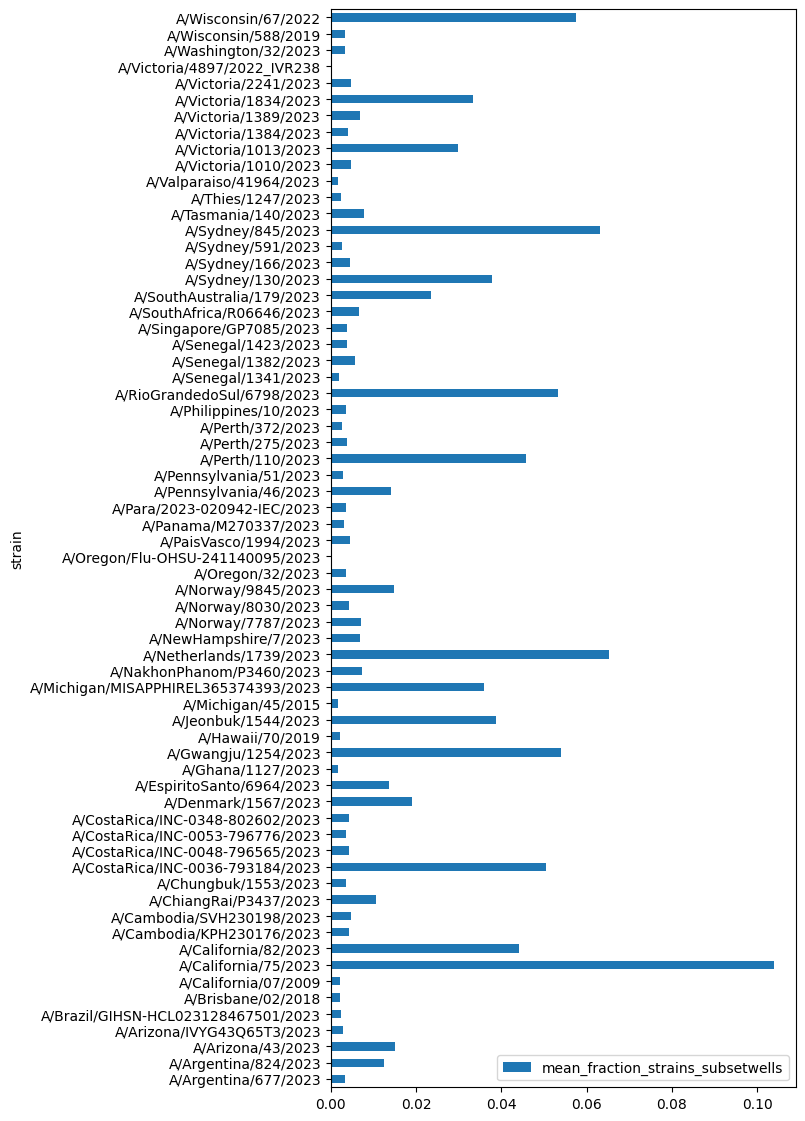

In [34]:
(mean_single_well
                 [['strain', 'mean_fraction_strains_subsetwells']]
                 .drop_duplicates()
                 .plot.barh(x="strain", y="mean_fraction_strains_subsetwells", figsize = (6,14), log=False)
)
plt.savefig('../librarypooling/repool_meanfraction.png', 
            dpi = 'figure',
            bbox_inches = 'tight')


In [36]:
def run_balancestrains(dataframe):

    balance_chart = (
        alt.Chart(dataframe)
        .encode(
            alt.X(
                "mean_fraction_strains_subsetwells",
                title="fraction transcriptional titer",
                scale=alt.Scale(nice=False, padding=4,),
                axis=alt.Axis(labelOverlap=True),
            ),
            alt.Y("strain", sort=viruses),
        )
        .mark_line(point=True)
        .configure_axis(grid=False)
        .configure_point(size=45)
    )

    return balance_chart

run_balancestrains(mean_single_well.loc[mean_single_well['well']=='D1'])

alt.Chart(...)

,strain,mean_fraction_strains_subsetwells,mean_ratio_to_add,est_tcid50
0,A/Argentina/677/2023,0.003396,4.600769,3789.148912
3,A/Argentina/824/2023,0.012494,1.250640,13939.266433
6,A/Arizona/43/2023,0.015019,1.040346,16756.930530
9,A/Arizona/IVYG43Q65T3/2023,0.002954,5.289779,3295.600751
12,A/Brazil/GIHSN-HCL023128467501/2023,0.002313,6.755766,2580.462305
...,...,...,...,...
182,A/Victoria/2241/2023,0.004642,3.366016,5179.119080
185,A/Victoria/4897/2022_IVR238,0.000000,inf,0.000000
188,A/Washington/32/2023,0.003251,4.806753,3626.772334
191,A/Wisconsin/588/2019,0.003433,4.551073,3830.524942


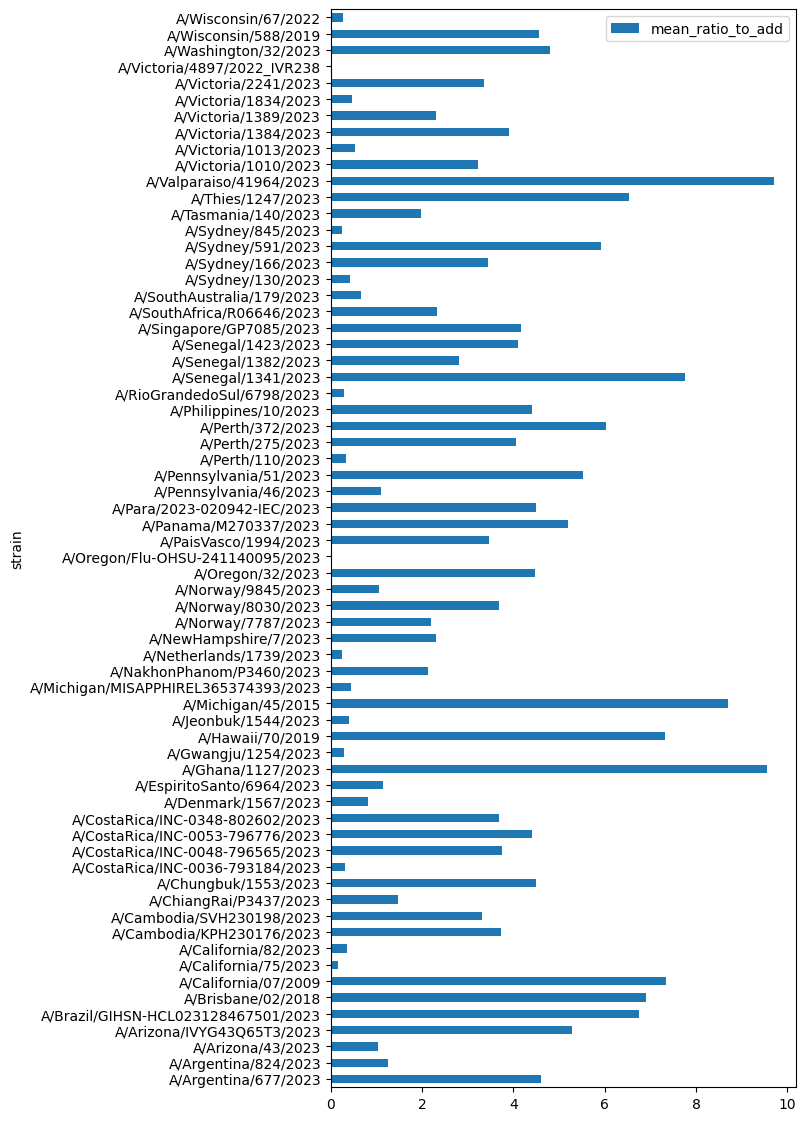

In [37]:
tidy = mean_single_well[['strain', 'mean_fraction_strains_subsetwells', 'mean_ratio_to_add', 'est_tcid50']].drop_duplicates()
tidy.plot.barh(x="strain", y="mean_ratio_to_add", figsize = (6,14))
plt.savefig('../librarypooling/repool_mean_ratio_to_add.png',
            dpi = 'figure',
            bbox_inches = 'tight')
tidy

In [38]:
tidy['vol_to_add'] = tidy['mean_ratio_to_add'].apply(lambda x: x * 70).to_list()

In [39]:
tidy[['strain','vol_to_add','est_tcid50']].to_csv('../librarypooling/repool_volumes_withtiter_wellsDandE_fixedvolumes.csv')

<Axes: ylabel='strain_barcode'>

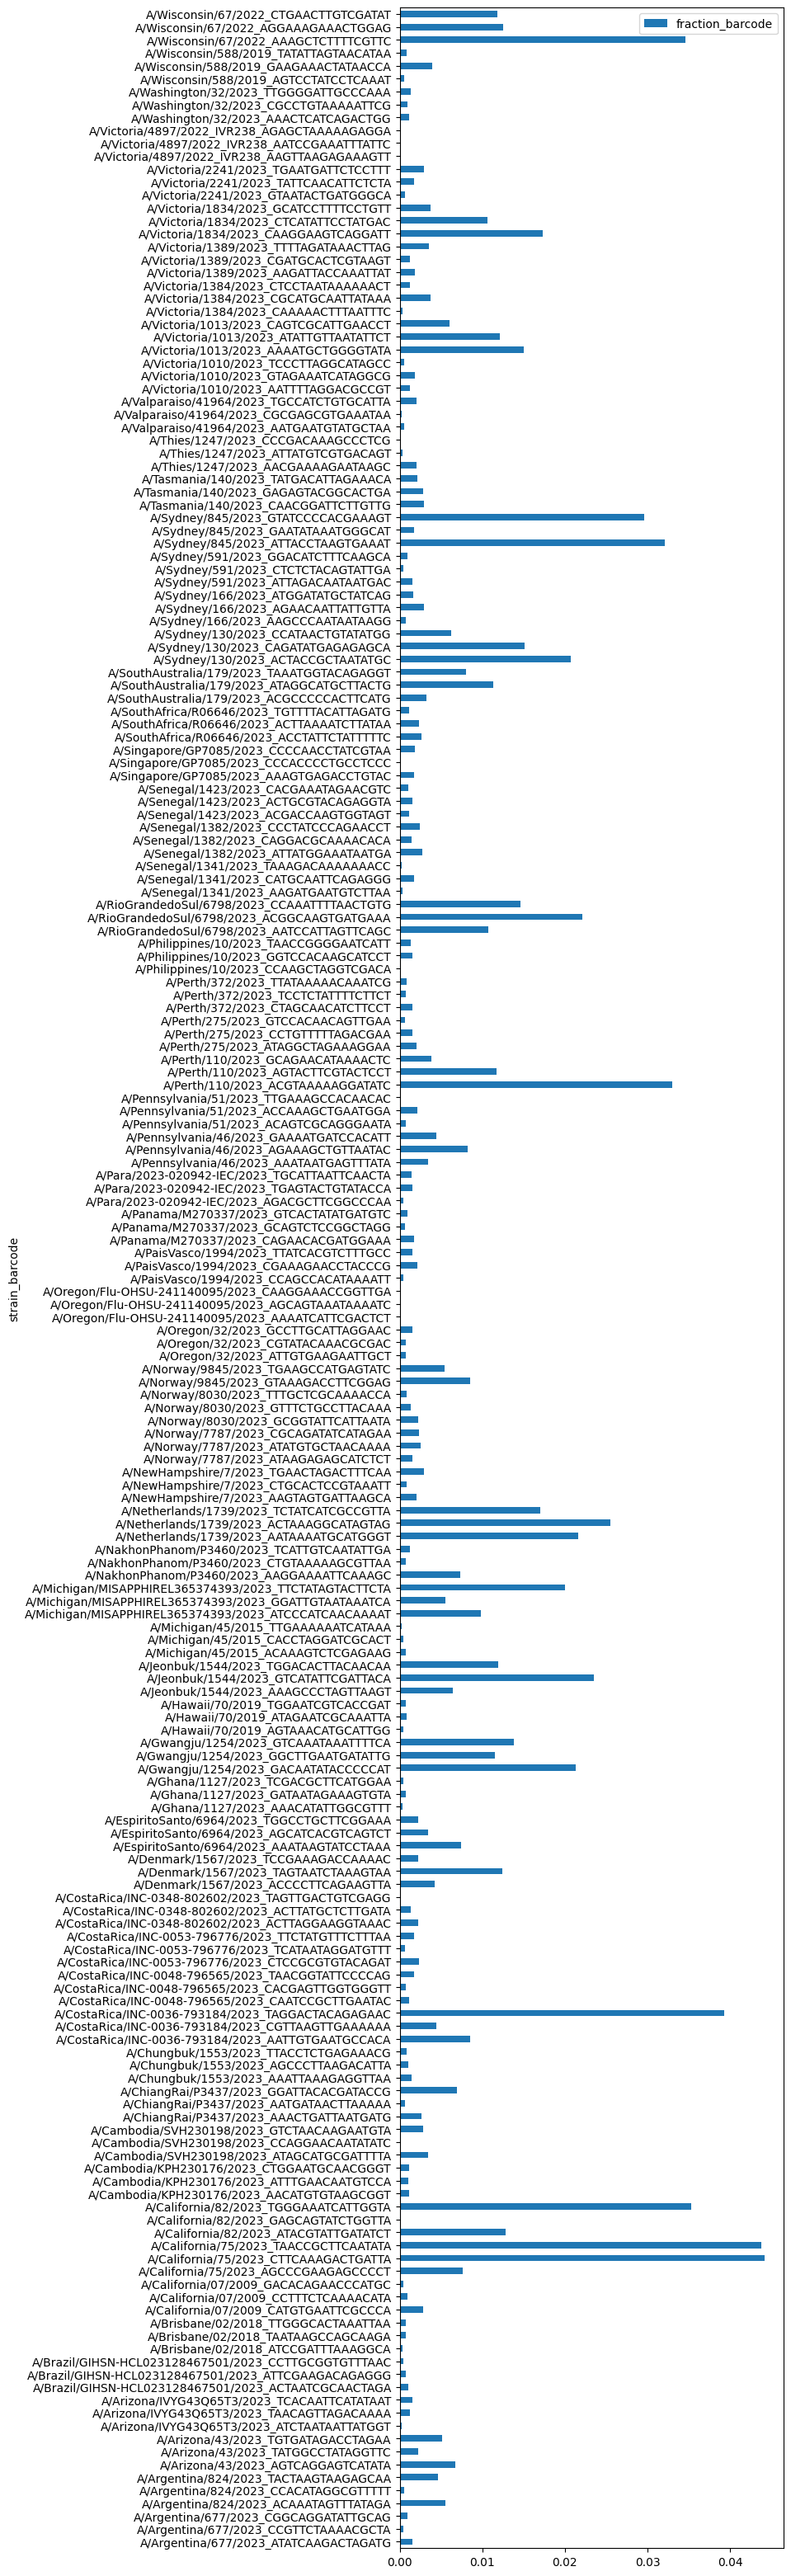

In [40]:
#tidy = mean_single_well[['strain','barcode', 'mean_fraction_strains', 'mean_ratio_to_add', 'est_tcid50']].drop_duplicates()
#tidy.plot.barh(x="barcode", y="mean_ratio_to_add", figsize = (6,14))
#plt.savefig('../results/librarytiterbarcodecounts/mean_ratio_to_add.png',
#            dpi = 'figure',
#            bbox_inches = 'tight')

mean_single_well['strain_barcode'] = mean_single_well['strain'] + "_" + mean_single_well['barcode'].str[0:16]
mean_single_well.loc[mean_single_well['well'].str.contains('D1')].plot.barh(x="strain_barcode", y="fraction_barcode", figsize = (6,40), log=False)



In [41]:
assess_barcodebalancing = mean_single_well.loc[mean_single_well['well'].str.contains('D1')][['strain','barcode','strain_barcode','fraction_barcode','count','counts_perwell']]
assess_barcodebalancing_bystrain = assess_barcodebalancing.groupby(['strain'])['count'].sum().to_frame().rename(columns = {'count': 'count_perstrain_perwell'}).reset_index()
assess_barcodebalancing_bystrain
assess_barcodebalancing = assess_barcodebalancing.merge(assess_barcodebalancing_bystrain, on="strain")
assess_barcodebalancing['fraction_of_strain_barcode'] = assess_barcodebalancing['count']/assess_barcodebalancing['count_perstrain_perwell']
assess_barcodebalancing

,strain,barcode,strain_barcode,fraction_barcode,count,counts_perwell,count_perstrain_perwell,fraction_of_strain_barcode
0,A/Argentina/677/2023,ATATCAAGACTAGATG,A/Argentina/677/2023_ATATCAAGACTAGATG,0.001548,6609,4269778,12153,0.543816
1,A/Argentina/677/2023,CCGTTCTAAAACGCTA,A/Argentina/677/2023_CCGTTCTAAAACGCTA,0.000402,1715,4269778,12153,0.141117
2,A/Argentina/677/2023,CGGCAGGATATTGCAG,A/Argentina/677/2023_CGGCAGGATATTGCAG,0.000897,3829,4269778,12153,0.315066
3,A/Argentina/824/2023,ACAAATAGTTTATAGA,A/Argentina/824/2023_ACAAATAGTTTATAGA,0.005508,23518,4269778,45587,0.515893
4,A/Argentina/824/2023,CCACATAGGCGTTTTT,A/Argentina/824/2023_CCACATAGGCGTTTTT,0.000572,2444,4269778,45587,0.053612
...,...,...,...,...,...,...,...,...
192,A/Wisconsin/588/2019,GAAGAAACTATAACCA,A/Wisconsin/588/2019_GAAGAAACTATAACCA,0.003944,16842,4269778,23066,0.730166
193,A/Wisconsin/588/2019,TATATTAGTAACATAA,A/Wisconsin/588/2019_TATATTAGTAACATAA,0.000864,3687,4269778,23066,0.159846
194,A/Wisconsin/67/2022,AAAGCTCTTTTCGTTC,A/Wisconsin/67/2022_AAAGCTCTTTTCGTTC,0.034607,147764,4269778,251836,0.586747
195,A/Wisconsin/67/2022,AGGAAAGAAACTGGAG,A/Wisconsin/67/2022_AGGAAAGAAACTGGAG,0.012565,53651,4269778,251836,0.213039


alt.Chart(...)

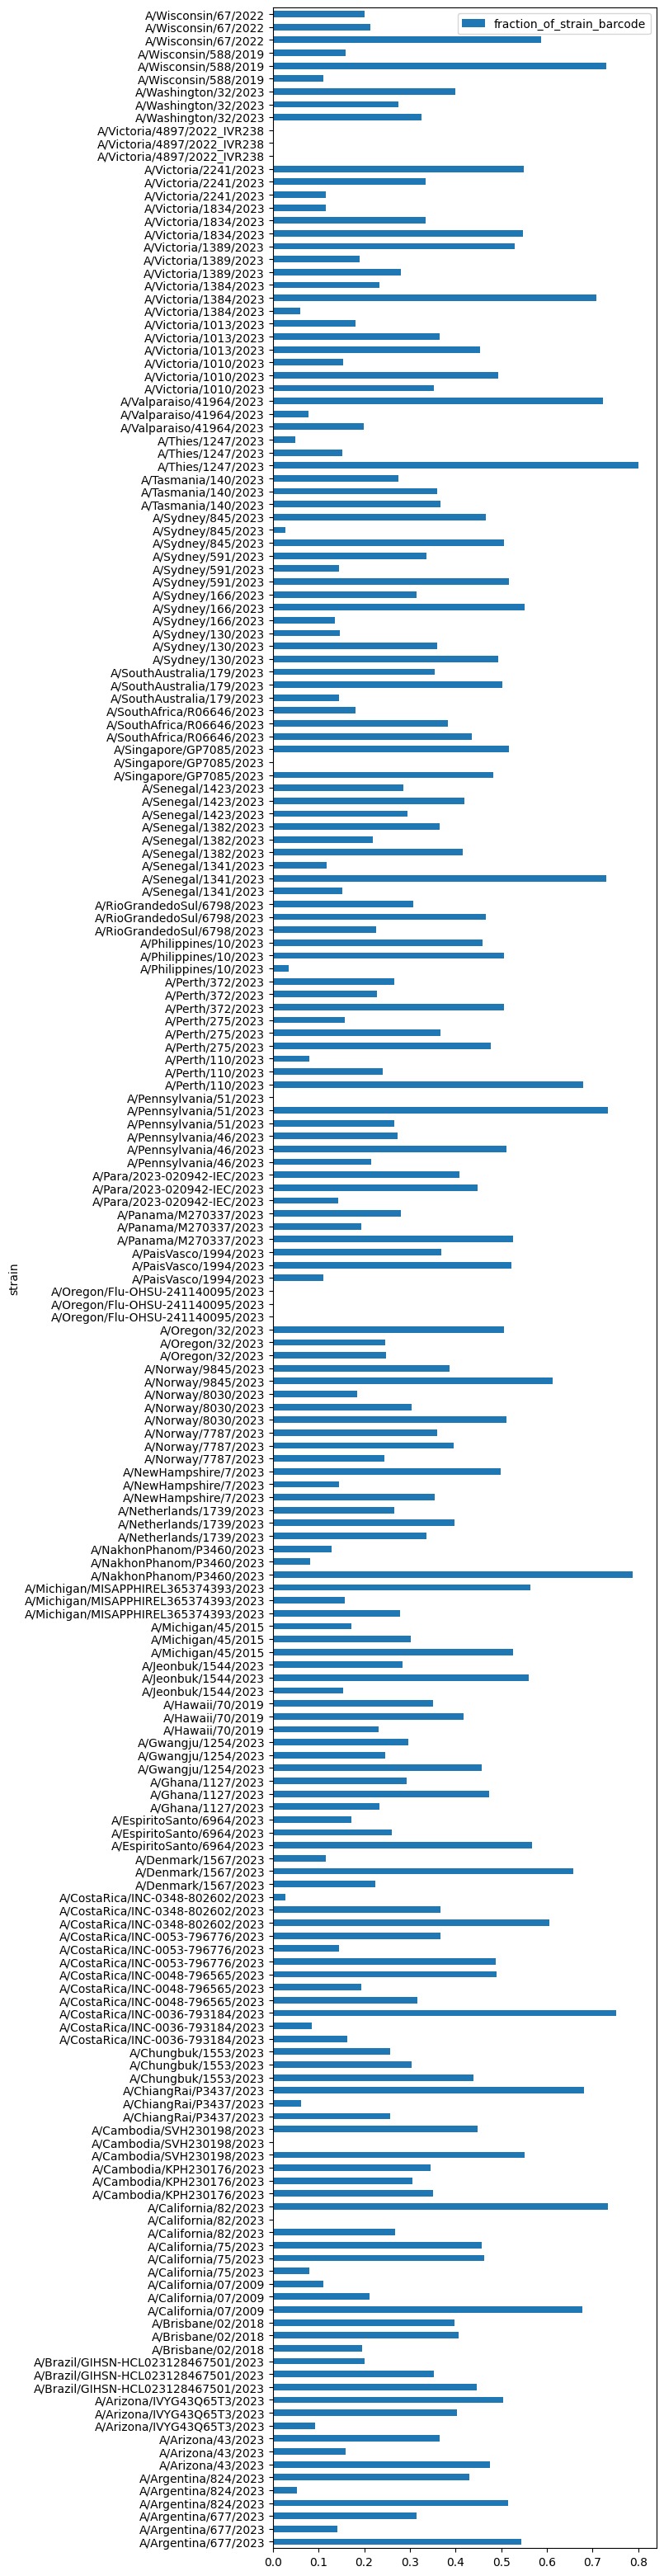

In [42]:
assess_barcodebalancing.plot.barh(x="strain", y="fraction_of_strain_barcode", figsize = (6,40), log=False)


barcode_balance_chart = (
    alt.Chart(assess_barcodebalancing)
    .encode(
        alt.X("fraction_of_strain_barcode", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "strain",
            title=None,
            sort=sample_wells,
        ),
        alt.Color("barcode", sort=sorted(assess_barcodebalancing["strain"].unique())).scale(range = ['steelblue', 'goldenrod','firebrick']),
    )
    .mark_bar(height={"band": 0.75})
    .properties(
        height=alt.Step(14),
        width=250,
    )
    .configure_axis(grid=False,labelFontSize=15,titleFontSize=18,labelLimit=300)
)

barcode_balance_chart